In [ ]:
function ELBO

LoadError: UndefVarError: `TDCModel` not defined

In [1]:
# function update_categorical_variational_distribution(
#     params              :: Vector{T},
#     modelloglikelihood_func, 
#     storage_samples     :: Vector{Vector{Int}};
#     step                :: T = 1e-2,
#     maxiter             :: Int = 100000,
#     verbose             :: Bool = true,
#     storage1            :: Vector{T} = nothing,
#     storage2            :: Vector{T} = nothing,
#     storage3            :: Vector{T} = nothing,
#     storage4            :: Vector{T} = nothing
# ) where T <: AbstractFloat
#     # Storage for gradient terms
#     grad_log_q = storage1
#     grad_L = model.storage2
#     if storage_grad1 == nothing
#         grad_log_q = similar(params)
#     end
#     if storage_grad2 == nothing
#         grad_L = similar(params)
#     end
#     # Storage for intermediate term in gradient calculations
#     D_beta = storage3
#     rho_star_old_i = storage4
#     if storage3 == nothing
#         D_beta = similar(params)
#     end
#     if storage4 == nothing
#         rho_star_old_i = similar(params)
#     end
#     M = size(storage_samples, 1)
#     # Perform gradient descent update of i-th π*    
#     @inbounds for iter in 1:maxiter
#         # Rho is unique up to a constant addative term
#         rho_star_old_i = log.(params)
#         # Sample Z with current π*
#         categorical_variational_distribution = Multinomial(1, params)
#         # Populate preallocated arrays with samples from variational distribution
#         rand!(categorical_variational_distribution, storage_samples)
#         # Set gradient of ELBO to 0
#         fill!(grad_L, 0)
#         # Rao Blackwellized ELBO
#         ELBO = 0
#         # Calculate the gradient estimate of the m-th sample
#         @inbounds for m in 1:M
#             z_m = storage_samples[m]
#             # Calculate gradient of log(q_1i(Z_i)) w.r.t. π*_i
#             grad_log_q .= z_m .- params
#             # Calculate log(q_1i(Z_i))
#             log_q = dot(z_m, log.(params))
#             # Get log likelihood of m-th sample
#             log_prob = modelloglikelihood_func(z_m)
#             # Update average gradient
#             grad_L .= (m - 1)/m .* grad_L + 1/m .* grad_log_q .* (log_prob - log_q)
#             # Update ELBO estimator
#             ELBO = (m-1)/m * ELBO + 1/m * (log_prob - log_q)
#         end
#         # Print ELBO, parameter and gradient if verbose
#         if verbose
#             println("ELBO: $ELBO")
#             println("π*_$i: $params")
#             println("gradient: $grad_L")
#         end
#         # Update with one step
#         rho_star_old_i .+= step * grad_L
#         # Convert logits into probabilities
#         params .= exp.(rho_star_old_i) ./ sum(exp.(rho_star_old_i))
#     end
# end

In [2]:
model.a_tau_star

LoadError: UndefVarError: `model` not defined

In [3]:
include("TDCM_modelling.jl")

In [4]:
using RCall

R"""
load("TDCM_multilevel_data.RData")
"""
TDCM_data = @rget data
Y = Array{Int, 3}(TDCM_data[:Y])
Q = convert(Matrix{Int64}, TDCM_data[:Q_matrix])
U = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_group])
for skill in TDCM_data[:X_ind]
    for time in 1:length(skill)
        if skill[time] isa Vector{<: Number}
            skill[time] = reshape(skill[time], :, 1)
        end
    end
end
X = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_ind])
group = Vector{Int64}(TDCM_data[:group])
obs = TDCMObs(Y, Q, U, X, group)

# R"""
# load("TDCM_multilevel_J50_data.RData")
# """
# TDCM_J50_data = @rget data_large_questions
# Y = Array{Int, 3}(TDCM_J50_data[:Y])
# Q = convert(Matrix{Int64}, TDCM_J50_data[:Q_matrix])
# U = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_group])
# for skill in TDCM_J50_data[:X_ind]
#     for time in 1:length(skill)
#         if skill[time] isa Vector{<: Number}
#             skill[time] = reshape(skill[time], :, 1)
#         end
#     end
# end
# X = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_ind])
# group = Vector{Int64}(TDCM_J50_data[:group])
# obs_J50 = TDCMObs(Y, Q, U, X, group)
;

In [5]:
N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)

mu_beta_prior = Vector{Vector{Float64}}(undef, J)
L_beta_prior = Vector{Matrix{Float64}}(undef, J)
for j in 1:J
    num_features = size(obs.D[j], 2)
    mu_beta_prior[j] = zeros(num_features)
    L_beta_prior[j] = Matrix(1.0I, num_features, num_features)
end

mu_omega_prior = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, K)
L_omega_prior = Vector{Vector{Vector{Vector{Matrix{Float64}}}}}(undef, K)
a_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)
b_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)

for k in 1:K
    mu_omega_prior[k] = Vector{Vector{Vector{Vector{Float64}}}}(undef, O)
    L_omega_prior[k] = Vector{Vector{Vector{Matrix{Float64}}}}(undef, O)
    a_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    b_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    for t in 1:O
        num_features_gamma = size(obs.X[k][t], 2)
        num_features_omega = size(obs.U[k][t], 2)
        if t == 1
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 1)
            mu_omega_prior[k][t][1] = Vector{Vector{Float64}}(undef, 1)
            mu_omega_prior[k][t][1][1] = zeros(num_features_omega)

            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 1)
            L_omega_prior[k][t][1] = Vector{Matrix{Float64}}(undef, 1)
            L_omega_prior[k][t][1][1] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)

            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            a_tau_prior[k][t][1] = [3.0]

            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            b_tau_prior[k][t][1] = [3.0]
        else
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 2)
            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 2)
            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            for z in 1:2
                mu_omega_prior[k][t][z] = Vector{Vector{Float64}}(undef, num_features_gamma)
                L_omega_prior[k][t][z] = Vector{Matrix{Float64}}(undef, num_features_gamma)
                a_tau_prior[k][t][z] = ones(num_features_gamma) .* 3
                b_tau_prior[k][t][z] = ones(num_features_gamma) .* 3
                for m in 1:num_features_gamma
                    mu_omega_prior[k][t][z][m] = zeros(num_features_omega)
                    L_omega_prior[k][t][z][m] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)
                end
            end
        end
    end
end

M = 100
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)

# J50 = size(obs_J50.Y, 3)
# mu_beta_prior = Vector{Vector{Float64}}(undef, J50)
# V_beta_prior = Vector{Matrix{Float64}}(undef, J50)
# for j in 1:J50
#     num_features = size(obs_J50.D[j], 2)
#     mu_beta_prior[j] = zeros(num_features)
#     V_beta_prior[j] = Matrix(1.0I, num_features, num_features)
# end
# model_J50 = TDCModel(obs_J50, mu_beta_prior, V_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=false)
;

TDCModel constructed for computation on 16 threads


In [48]:
# @resumable pi_t1_loglike = function(Z :: Vector{Int}, Y, :: Vector{Int}, D_beta :: Vector{AbstractFloat})
#     for m in 1:model.M
#         J = size(Y)
#         log_prob_YZ = 0
#         for j in 1:J
#             mul!(D_beta, D[j], beta_sample[j][m])
#             log_prob_YZ += dot(z_im, log.(sigmoid.((2*Y[i, 1, j] - 1) .* D_beta)))
#         end
#         skill_profile = obs.skill_dict[argmax(z_im)]
#         for k in 1:K
#             log_prob_YZ += log(sigmoid((2*skill_profile[k] - 1) * dot(gamma_sample[k][1][1][group_i][m], obs.X[k][1][i])))
#         end
#     end
# end

**Estimating attribute profiles from uniform initialization**

In [76]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [77]:
# Fix true values of gamma and betas
for k in 1:K
    for s in S
        model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
        model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
    end
end
# for j in 1:J
#     model.mu_beta_star[j] = data[:beta][j]
#     model.V_beta_star[j] = model.V_beta_star[j] ./ 100
# end

# Sample beta and gammas
sample_β(model)
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

In [78]:
for i in 1:50
    update_categorical_variational_distribution(model, step=.01, maxiter=10, verbose=false)
    #update_categorical_variational_distribution2(model, 2, step=.01, maxiter=1, verbose=false)
    update_normal_variational_distribution(model, init_step = .006, maxiter = 3, verbose = false)
end

In [79]:
skill_profiles = Dict(1=>[0, 0], 
                 2=>[0, 1],
                 3=>[1, 0],
                 4=>[1, 1])

skill_numbers = Dict([0, 0]=>1, 
                 [0, 1]=>2,
                 [1, 0]=>3,
                 [1, 1]=>4)

preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][1])]
    actual = Vector{Int}(data[:profiles][i, :, 1])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [80]:
attribute_accs

4-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0

In [81]:
preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [82]:
attribute_accs

4-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0

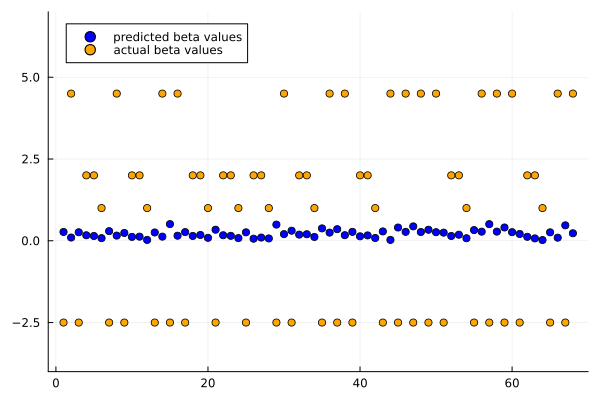

In [83]:
pred_beta_values = []
actual_beta_values = []
for j in 1:25
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

**Estimating Item response parameters with correct attribute profiles**

In [35]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [44]:
profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
                 [0, 1]=>[0.001, 0.997, 0.001, 0.001],
                 [1, 0]=>[0.001, 0.001, 0.997, 0.001],
                 [1, 1]=>[0.001, 0.001, 0.001, 0.997])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

In [45]:
update_normal_variational_distribution(model, init_step = .0001, maxiter = 100, verbose = false)

In [46]:
pred_beta_values = []
actual_beta_values = []
for j in 1:25
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

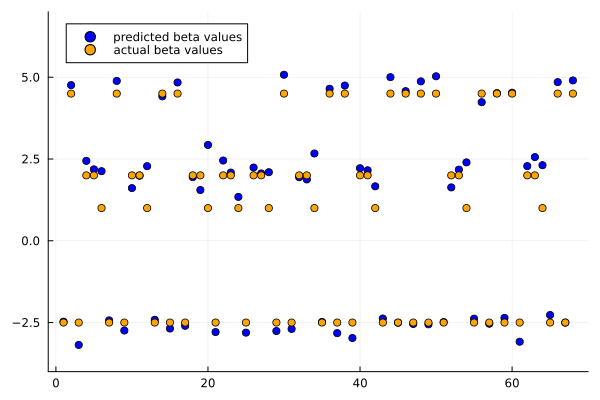

In [47]:
using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

**Estimating gamma with correct attribute profiles, gamma, and tau**

In [282]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [283]:
profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
                 [0, 1]=>[0.001, 0.997, 0.001, 0.001],
                 [1, 0]=>[0.001, 0.001, 0.997, 0.001],
                 [1, 1]=>[0.001, 0.001, 0.001, 0.997])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Fix true values of omega and make tau small
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 100
                model.a_tau_star[k][t][1][feature] = 10
                model.b_tau_star[k][t][1][feature] = 0.01
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, :, feature]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./ 100
                    model.a_tau_star[k][t][z + 1][feature] = 10
                    model.b_tau_star[k][t][z + 1][feature] = 0.01
                end
            end
        end
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [286]:
update_normal_variational_distribution2(model, init_step = .01, maxiter = 500, verbose = false)

In [287]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

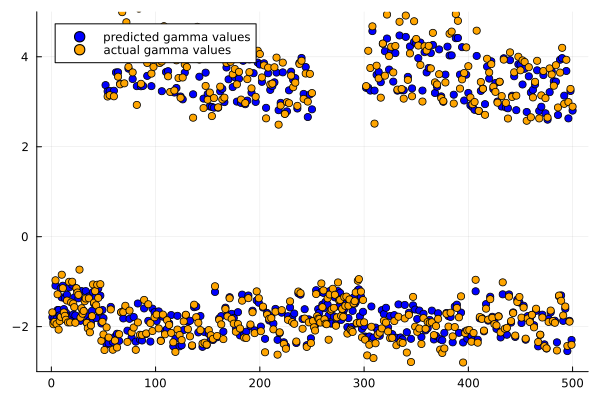

In [288]:
using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-3, 5)

**Estimating omega with correct gamma**

In [255]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [ ]:
# Fix true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] ./ 100
                end
            end
        end
    end
end


# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample tau
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [266]:
update_normal_variational_distribution3(model, init_step = .1, maxiter = 400, verbose = false)

In [267]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, :, feature])
                end
            end
        end
    end
end

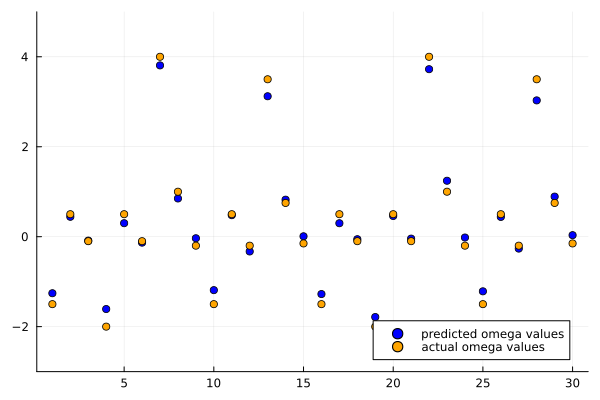

In [268]:
using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-3, 5)

**Estimate Gamma and Omega simultaneously**

In [294]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [295]:
profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
                 [0, 1]=>[0.001, 0.997, 0.001, 0.001],
                 [1, 0]=>[0.001, 0.001, 0.997, 0.001],
                 [1, 1]=>[0.001, 0.001, 0.001, 0.997])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                #model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.a_tau_star[k][t][1][feature] = 10
                model.b_tau_star[k][t][1][feature] = .01
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    #model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, :, feature]
                    model.a_tau_star[k][t][z + 1][feature] = 10
                    model.b_tau_star[k][t][z + 1][feature] = .01
                end
            end
        end
    end
end

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [305]:
for i in 1:100
    update_normal_variational_distribution2(model, init_step = .1, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end

    update_normal_variational_distribution3(model, init_step = .1, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_ω(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_ω(model, k, t, z, feature)
                    end
                end
            end
        end
    end

    update_inverse_gamma_distribution(model, step = .1, maxiter = 30, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_τ(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_τ(model, k, t, z, feature)
                    end
                end
            end
        end
    end
end

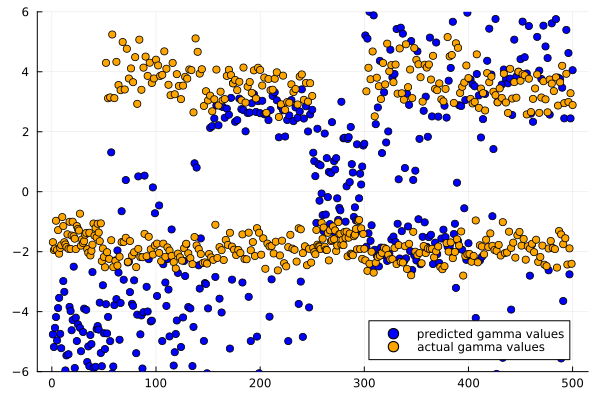

In [306]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-6, 6)

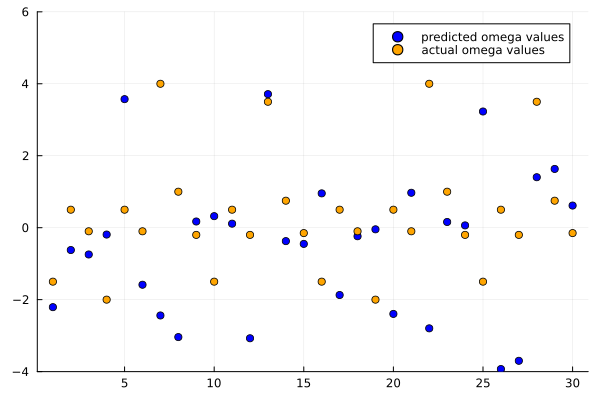

In [307]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, :, feature])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [308]:
model.V_omega_star

2-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[5.544079388983386 2.3265995249707134 -0.8288918007053369; 2.3265995249707134 5.402896631828825 -2.2108412540728026; -0.8288918007053369 -2.2108412540728026 1.0679078904977348]]], [[[2.0541221529476603 0.42006840729780265 -0.24905628583695633; 0.42006840729780265 0.5319739751844637 0.36613017312717366; -0.24905628583695633 0.36613017312717366 0.4241614340464776], [2.500665483417103 0.5666705995718333 -2.3158814224936664; 0.5666705995718333 1.5335177929686998 -0.8063148750775713; -2.3158814224936664 -0.8063148750775713 2.229188457250281]], [[2.2047788871251055 -0.2226407654515409 -0.31554293081041734; -0.2226407654515409 0.8846634259852871 -0.04809293506555829; -0.31554293081041734 -0.04809293506555829 0.08889920371034414], [0.9117840722060988 0.6274697431288729 0.37907048169019875; 0.6274697431288729 1.225984461671084 0.37602736318635577; 0.37907048169019875 0.37602736318635577 0.17432470699418912]]]]
 [[[[3.929664883322425

In [245]:
model.b_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]

**Estimating full TDCM model**

In [17]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [18]:
# Initialize small tau values
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = 3
#                 model.b_tau_star[k][t][1][feature] = 3
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = 3
#                     model.b_tau_star[k][t][z + 1][feature] = 3
#                 end
#             end
#         end
#     end
# end

# Initialize positive gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= 2.0
                #model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= 2.0
                    #model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] ./ 100
                end
            end
        end
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [42]:
for iter in 1:100
    update_categorical_variational_distribution(model, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 1)
    end

    update_categorical_variational_distribution2(model, 2, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 2)
    end

    update_normal_variational_distribution(model, init_step = .03, maxiter = 10, verbose = false)
    sample_β(model)

    update_normal_variational_distribution2(model, init_step = .03, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end

    update_normal_variational_distribution3(model, init_step = .1, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_ω(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_ω(model, k, t, z, feature)
                    end
                end
            end
        end
    end

    update_inverse_gamma_distribution(model, step = 1.0, maxiter = 10, verbose=false)
end

In [28]:
skill_profiles = Dict(4=>[0, 0], 
                 3=>[0, 1],
                 2=>[1, 0],
                 1=>[1, 1])

skill_numbers = Dict([0, 0]=>4, 
                 [0, 1]=>3,
                 [1, 0]=>2,
                 [1, 1]=>1)

preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][1])]
    actual = Vector{Int}(data[:profiles][i, :, 1])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [29]:
attribute_accs

4-element Vector{Float64}:
 1.0
 0.8950354609929078
 0.8097982708933718
 0.9857309260337799

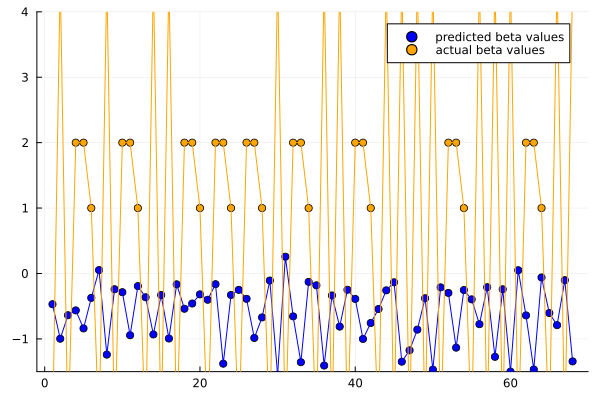

In [30]:
pred_beta_values = []
actual_beta_values = []
for j in 1:25
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
plot!(x, pred_beta_values, label = "", lc=:blue)
plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-1.5, 4)

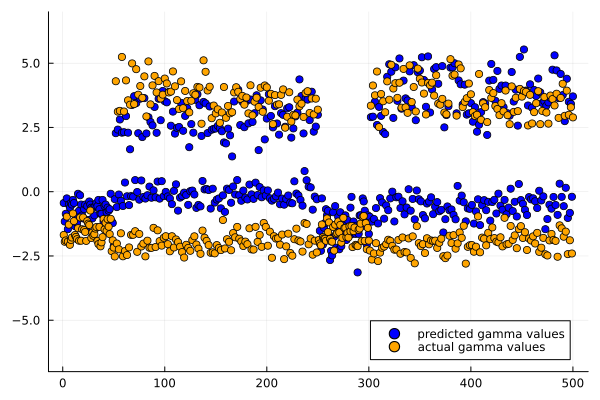

In [41]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, -pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-7, 7)

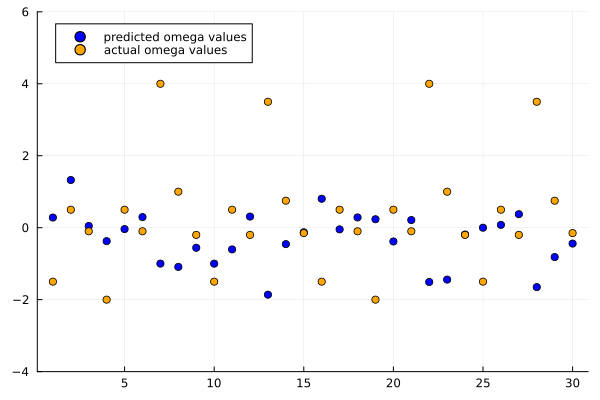

In [32]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, :, feature])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [39]:
model.mu_gamma_star[1][2][1][10]

2-element Vector{Float64}:
  0.1943367683806157
 -3.7175156622467287

In [40]:
data[:gamma][1][2][1, 10, :]

2-element Vector{Float64}:
 -1.6764247417449951
  3.409348964691162